# Chapter 8 - Exercise Solutions - Applied

In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

from sklearn.metrics import mean_squared_error
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsClassifier

## 7

In Section 8.3.3, we applied random forests to the `Boston` data using `max_features = 6` and using `n_estimators = 100` and `n_estimators = 500`. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for `max_features` and `n_estimators`. You can model your plot after Figure 8.10. Describe the results obtained.

In [2]:
Boston = load_data("Boston")
X = Boston.drop('medv', axis=1)
y = Boston['medv']
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y, test_size=0.3, random_state=0)

p = X_train.shape[1]

In [3]:
def getMSE(model, X_test):
    y_pred = model.predict(X_test)
    return ((y_test - y_pred)**2).mean()

In [4]:
mse_p = []
mse_p2 = []
mse_psqrt = []
tree_number = range(1,101)
for B in tree_number:
    BostonRandForest_p = RF(max_features=p, n_estimators=B, random_state=0).fit(X_train, y_train)
    BostonRandForest_p2 = RF(max_features=int(p/2), n_estimators=B, random_state=0).fit(X_train, y_train)
    BostonRandForest_psqrt = RF(max_features=int(np.sqrt(p)), n_estimators=B, random_state=0).fit(X_train, y_train)
    mse_p.append(getMSE(BostonRandForest_p, X_test))
    mse_p2.append(getMSE(BostonRandForest_p2, X_test))
    mse_psqrt.append(getMSE(BostonRandForest_psqrt, X_test))

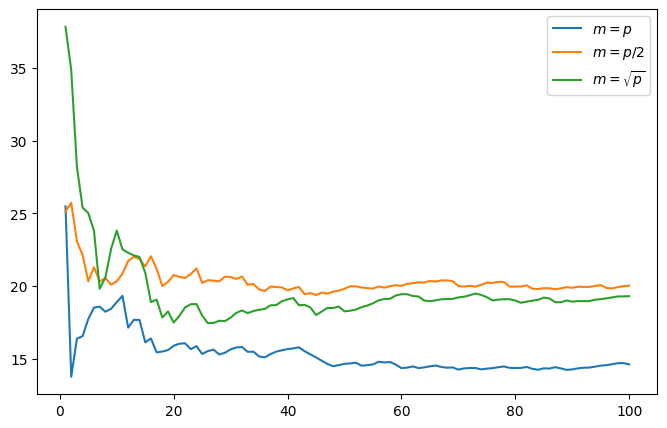

In [5]:
fig, ax = subplots(figsize=(8,5))
ax.plot(tree_number, mse_p, c='tab:blue', label='$m=p$')
ax.plot(tree_number, mse_p2, c='tab:orange', label='$m=p/2$')
ax.plot(tree_number, mse_psqrt, c='tab:green', label='$m=\sqrt{p}$')
ax.legend();

The mean-squared error stabilizes at around 50 trees or above. Bagging $(m=p)$ performs best, followed by random forests with $m=\sqrt{p}$, and random forest with $m=p/2$.

## 8

In the lab, a classification tree was applied to the `Carseats` data set after converting `Sales` into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

**(a)**  Split the data set into a training set and a test set.

In [6]:
Carseats = load_data('Carseats')
Carseats['ShelveLocGood'] = np.where(Carseats['ShelveLoc'] == 'Good', 1, 0)
Carseats['ShelveLocMedium'] = np.where(Carseats['ShelveLoc'] == 'Medium', 1, 0)
Carseats['UrbanBin'] = np.where(Carseats['Urban'] == 'Yes', 1, 0)
Carseats['USbin'] = np.where(Carseats['US'] == 'Yes', 1, 0)

In [7]:
X = Carseats.drop(['Sales', 'ShelveLoc', 'Urban', 'US'], axis=1)
y = Carseats['Sales']
feature_names = X.columns

(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y, test_size=0.3, random_state=1)

**(b)** Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [8]:
CarseatsDTR = DTR(max_depth=10).fit(X_train, y_train)
getMSE(CarseatsDTR, X_test)

6.1075667082105065

In [9]:
y_pred = CarseatsDTR.predict(X_test)
CarseatsDTR.score(X_test, y_test)

0.2219608478284003

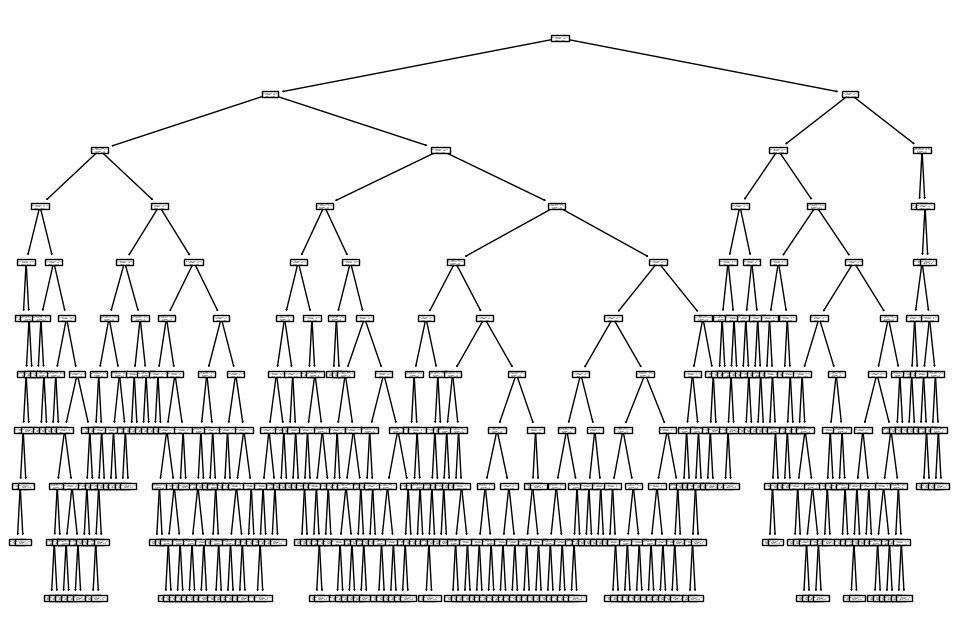

In [10]:
fig, ax = subplots(figsize=(12,8))
plot_tree(CarseatsDTR, feature_names=feature_names, ax=ax);

The score of 0.44 is fairly low. The most influential predictors seem to be `ShelveLocGood`, `ShelveLocMedium`, `Price`, and `Age`.

**(c)** Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [11]:
p_grid = {'max_depth': range(1,10)} # Parameters over which to do grid search

kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(CarseatsDTR, p_grid, refit=True, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeRegressor(max_depth=10),
             param_grid={'max_depth': range(1, 10)},
             scoring='neg_mean_squared_error')

In [12]:
grid.best_params_, grid.best_estimator_

({'max_depth': 3}, DecisionTreeRegressor(max_depth=3))

The optimal `max_depth` is 3.

In [13]:
ccp_path = CarseatsDTR.cost_complexity_pruning_path(X_train, y_train)
p_grid = {'ccp_alpha': ccp_path.ccp_alphas} # Parameters over which to do grid search

kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(CarseatsDTR, p_grid, refit=True, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeRegressor(max_depth=10),
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.78571429e-07, 1.78571429e-07, 7.14285714e-07,
       7.14285714e-07, 7.14285714e-07, 1.60714286e-06, 1.60714286e-06,
       2.85714286e-06, 2.85714286e-06, 4.46428571e-06, 4.46428571e-06,
       4.46428571e-06, 4.46428571e-06,...
       6.13817986e-02, 6.52542917e-02, 7.19849115e-02, 7.81317202e-02,
       9.82415051e-02, 1.00871458e-01, 1.05930007e-01, 1.06127577e-01,
       1.08073545e-01, 1.39854982e-01, 1.43358979e-01, 1.60639885e-01,
       1.63118568e-01, 1.70941054e-01, 2.08424380e-01, 2.60050911e-01,
       3.86403132e-01, 4.65866100e-01, 5.28906835e-01, 9.20174083e-01,
       1.87163276e+00])},
             scoring='neg_mean_squared_error')

In [14]:
grid.best_params_, grid.best_estimator_ # Pruning has a positive alpha only if the tree is large enough (obviously)

({'ccp_alpha': 0.02280720238095313},
 DecisionTreeRegressor(ccp_alpha=0.02280720238095313, max_depth=10))

In [15]:
grid.best_estimator_.get_depth()

8

If `max_depth` is set higher, pruning finds an optimal alpha of 0.02, which results in a depth of 8.

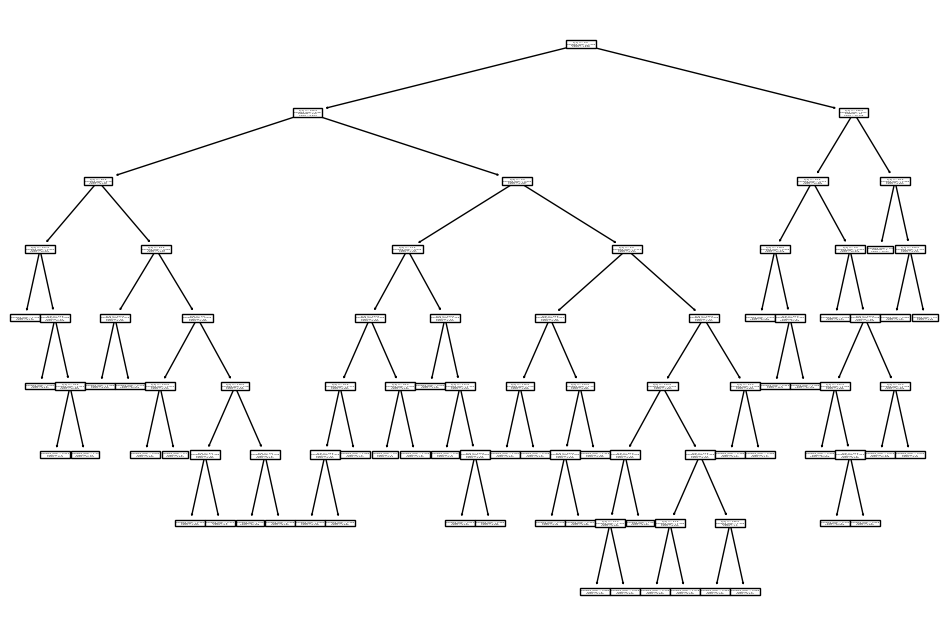

In [16]:
fig, ax = subplots(figsize=(12,8))
plot_tree(grid.best_estimator_, ax=ax);

**(d)** Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the `feature_importance_` values to determine which variables are most important.

In [17]:
p = X_train.shape[1]

CarseatRandForest = RF(max_features=p, n_estimators=100, random_state=0).fit(X_train, y_train)
getMSE(CarseatRandForest, X_test), CarseatRandForest.score(X_test, y_test)

(2.845216710416666, 0.6375495998854749)

In [18]:
feature_imp = pd.DataFrame(
    {'importance':CarseatRandForest.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.292837
ShelveLocGood,0.245605
Age,0.099413
CompPrice,0.094813
Advertising,0.072933
ShelveLocMedium,0.069201
Income,0.044713
Population,0.042667
Education,0.026245
UrbanBin,0.006556


**(e)** Use random forests to analyze this data. What test MSE do you obtain? Use the `feature_importance_` values to determine which variables are most important. Describe the effect of *m*, the number of variables considered at each split, on the error rate obtained.

In [19]:
CarseatRandForest_p = RF(max_features=p, n_estimators=100, random_state=0).fit(X_train, y_train)
importance_p = CarseatRandForest_p.feature_importances_
getMSE(CarseatRandForest_p, X_test), CarseatRandForest_p.score(X_test, y_test)

(2.845216710416666, 0.6375495998854749)

In [20]:
CarseatRandForest_p2 = RF(max_features=int(p/2), n_estimators=100, random_state=0).fit(X_train, y_train)
importance_p2 = CarseatRandForest_p2.feature_importances_
getMSE(CarseatRandForest_p2, X_test), CarseatRandForest_p2.score(X_test, y_test)

(2.698162710416666, 0.6562827181549216)

In [21]:
CarseatRandForest_sqrtp = RF(max_features=int(np.sqrt(p)), n_estimators=100, random_state=0).fit(X_train, y_train)
importance_sqrtp = CarseatRandForest_sqrtp.feature_importances_
getMSE(CarseatRandForest_sqrtp, X_test), CarseatRandForest_sqrtp.score(X_test, y_test)

(2.952200610416665, 0.6239209869159084)

In [22]:
feature_imp_m = pd.DataFrame(
    {'importance_p':importance_p, 'importance_p2':importance_p2, 'importance_sqrtp':importance_sqrtp},
    index=feature_names)
feature_imp_m.sort_values(by='importance_p', ascending=False)

,importance_p,importance_p2,importance_sqrtp
Price,0.292837,0.272902,0.253376
ShelveLocGood,0.245605,0.212860,0.175667
Age,0.099413,0.100472,0.112812
CompPrice,0.094813,0.096014,0.093678
Advertising,0.072933,0.091134,0.099490
ShelveLocMedium,0.069201,0.053427,0.035447
Income,0.044713,0.060478,0.079366
Population,0.042667,0.060660,0.076894
Education,0.026245,0.037088,0.046434
UrbanBin,0.006556,0.006018,0.011015


The order of variables by importance is roughly the same for different values of $m: p, p/2, \sqrt{p} $. (Only $\sqrt{p}$ is slightly different for importances of `CompPrice` and below.)

**(f)** Now analyze the data using BART, and report your results.

In [23]:
CarseatBART = BART(random_state=0, burnin=5, ndraw=15).fit(X_train, y_train)

In [24]:
y_pred_BART = CarseatBART.predict(np.asarray(X_test))
np.mean((y_test - y_pred_BART)**2), CarseatBART.score(np.asarray(X_test), y_test)

(1.4183313103060031, 0.8193196500522149)

With an MSE of 1.4 and an $R^2$ of 0.82, the BART method outperforms bagging and random forests.

## 9

This problem involves the OJ data set which is part of the ISLP package.

**(a)** Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [25]:
OJ = load_data('OJ')
OJ['PurchaseCH'] = np.where(OJ['Purchase']=='CH', 1, 0)
OJ['Store7bin'] = np.where(OJ['Store7']=='Yes', 1, 0)

In [26]:
X = OJ.drop(['Purchase', 'PurchaseCH', 'Store7'], axis=1)
y = OJ['PurchaseCH']

In [27]:
OJ_feature_names = X.columns

(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y, train_size=800, random_state=1)

**(b)** Fit a tree to the training data, with `Purchase` as the response and the other variables as predictors. What is the training error rate?

In [28]:
OJ_DTC = DTC(criterion='entropy', max_depth=3, random_state=0).fit(X_train, y_train)

In [29]:
OJ_DTC.score(X_train, y_train), accuracy_score(y_train, OJ_DTC.predict(X_train))

(0.8325, 0.8325)

The *training* error rate is 0.83 with a `max_depth` of 3, and 0.86 with a `max_depth` of 5.

**(c)** Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have?

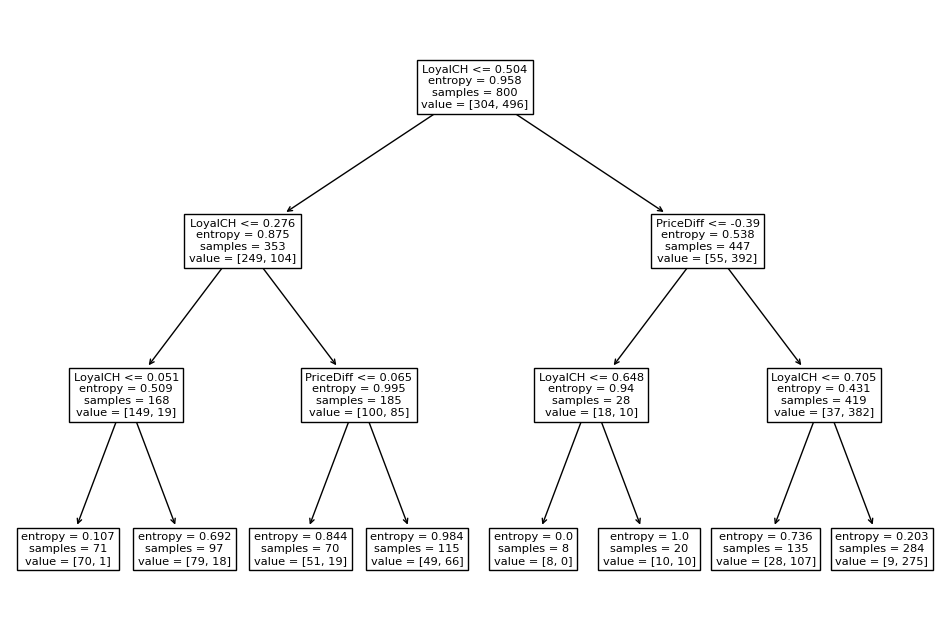

In [30]:
fig, ax = subplots(figsize=(12,8))
plot_tree(OJ_DTC, feature_names=OJ_feature_names, ax=ax);

At a `max_depth` of 3, the tree has 8 terminal nodes (as many as possible, i.e. $2^3=8$.) `LoyalCH` and `PriceDiff` overwhelmingly explain most of the variation in the tree.

**(d)** Use the `export_tree()` function to produce a text summary of the fitted tree. Pick one of the terminal nodes, and interpret the information displayed.

In [31]:
print(export_text(OJ_DTC, feature_names=OJ_feature_names, show_weights=True))

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.05
|   |   |   |--- weights: [70.00, 1.00] class: 0
|   |   |--- LoyalCH >  0.05
|   |   |   |--- weights: [79.00, 18.00] class: 0
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.07
|   |   |   |--- weights: [51.00, 19.00] class: 0
|   |   |--- PriceDiff >  0.07
|   |   |   |--- weights: [49.00, 66.00] class: 1
|--- LoyalCH >  0.50
|   |--- PriceDiff <= -0.39
|   |   |--- LoyalCH <= 0.65
|   |   |   |--- weights: [8.00, 0.00] class: 0
|   |   |--- LoyalCH >  0.65
|   |   |   |--- weights: [10.00, 10.00] class: 0
|   |--- PriceDiff >  -0.39
|   |   |--- LoyalCH <= 0.71
|   |   |   |--- weights: [28.00, 107.00] class: 1
|   |   |--- LoyalCH >  0.71
|   |   |   |--- weights: [9.00, 275.00] class: 1



For example, in the first node, all the branches relate to the `LoyalCH` predictor, the first node represeting observations for which `LoyalCH` is less than 0.05. There are 71 observations in this node, 70 of which are of value `0`, meaning `PurchaseCH` is false and the brand purchased was `MM`. The final prediction classification for this node is, appropriately, `0`.

**(e)**  Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [32]:
OJ_DTC.score(X_test, y_test)

0.8222222222222222

In [33]:
confusion_table(OJ_DTC.predict(X_test), y_test)

Truth,0,1
Predicted,,
0,78,13
1,35,144


In [34]:
(78+144)/(78+144+13+35)

0.8222222222222222

**(f)** Use cross-validation on the training set in order to determine the optimal tree size.

In [35]:
p_grid = {'max_depth': range(1,20)} # Parameters over which to do grid search

kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(OJ_DTC, p_grid, refit=True, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                              random_state=0),
             param_grid={'max_depth': range(1, 20)},
             scoring='neg_mean_squared_error')

In [36]:
grid.best_params_

{'max_depth': 3}

In [37]:
grid.best_estimator_.get_depth()

3

**(g)** Produce a plot with tree size on the *x*-axis and cross-validated classification error rate on the *y*-axis.

In [104]:
K = 10
OJ_DTC_loop = DTC(criterion='entropy', max_depth=3, random_state=0).fit(X_train, y_train)
kfold = skm.KFold(K, random_state=0, shuffle=True)
yhat_cv = skm.cross_val_predict(OJ_DTC_loop, X_train, y_train, cv=kfold)

In [105]:
error_cv = []
for train_idx, test_idx in kfold.split(y_train):
    # print(test_idx)
    error = 1 - accuracy_score(y_train.iloc[test_idx], yhat_cv[test_idx])
    error_cv.append(error)

print(f'Mean CV error: {np.array(error_cv).mean(axis=0)}')
print(f'Std CV error: {np.array(error_cv).std(axis=0)}')


Mean CV error: 0.19374999999999998
Std CV error: 0.04718646522044217


In [106]:
# Now, looping over `max_depth`
tree_max = 76
error_cv_mean = []
error_cv_se = []
tree_size = range(2,tree_max+1)
for B in tree_size:
    OJ_DTC_loop = DTC(criterion='entropy', max_leaf_nodes=B, random_state=0).fit(X_train, y_train)
    yhat_cv = skm.cross_val_predict(OJ_DTC_loop, X_train, y_train, cv=kfold)

    error_cv = []
    for train_idx, test_idx in kfold.split(y_train):
        error = 1 - accuracy_score(y_train.iloc[test_idx], yhat_cv[test_idx])
        error_cv.append(error)
    
    error_cv_mean.append(np.array(error_cv).mean(axis=0))
    error_cv_se.append(np.array(error_cv).std(axis=0) / np.sqrt(K))


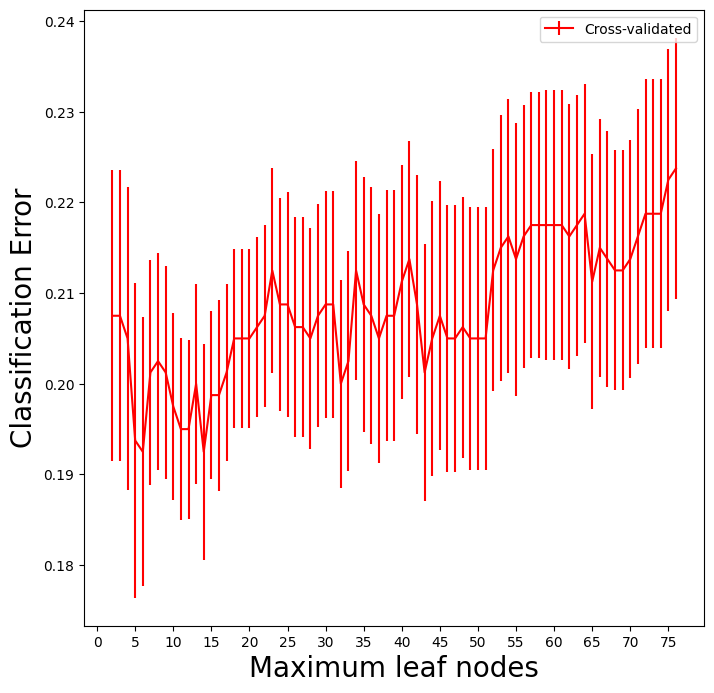

In [107]:
fig, ax = subplots(figsize=(8,8))
ax.set_ylabel('Classification Error', fontsize=20)
ax.set_xlabel('Maximum leaf nodes', fontsize=20)
ax.errorbar(range(2, tree_max+1), error_cv_mean, error_cv_se, label='Cross-validated', c='r')
ax.set_xticks(np.arange(tree_max)[::5])
ax.legend();

**(h)** Which tree size corresponds to the lowest cross-validated classification error rate?

In [117]:
np.argmin(error_cv_mean), error_cv_mean[12]

(12, 0.19249999999999998)

The lowest error rate corresponds to index 12, i.e. the 13th iteration; as leaf counts start at 2, this corresponds to a tree with 14 leaves/nodes. The error rate is 0.192.

In [124]:
OJ_DTC_cv_unpruned = DTC(criterion='entropy', max_leaf_nodes=14, random_state=0).fit(X_train, y_train)
OJ_DTC_cv_unpruned.get_n_leaves()

14

**(i)** Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

In [113]:
OJ_DTC_cv = DTC(criterion='entropy', max_depth=10, random_state=0).fit(X_train, y_train)

ccp_path = OJ_DTC_cv.cost_complexity_pruning_path(X_train, y_train)
p_grid = {'ccp_alpha': ccp_path.ccp_alphas} # Parameters over which to do grid search

kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(OJ_DTC_cv, p_grid, refit=True, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                              random_state=0),
             param_grid={'ccp_alpha': array([0.        , 0.00031081, 0.00045566, 0.000902  , 0.00094361,
       0.00125915, 0.00127173, 0.00131242, 0.00133208, 0.00171008,
       0.00173353, 0.00195218, 0.00224149, 0.00237517, 0.00237517,
       0.00243758, 0.0025    , 0...
       0.00339593, 0.00342016, 0.00358352, 0.00383526, 0.00412549,
       0.00413845, 0.00432529, 0.00451205, 0.00472601, 0.00473508,
       0.00475413, 0.00529803, 0.00574049, 0.00587038, 0.00640921,
       0.00653445, 0.00669822, 0.00714105, 0.00731179, 0.00791001,
       0.00888996, 0.00895499, 0.01166118, 0.01304567, 0.01353268,
       0.01486958, 0.029348  , 0.04209651, 0.04884197, 0.27148775])},
             scoring='neg_mean_squared_error')

In [114]:
grid.best_params_

{'ccp_alpha': 0.02934799878716471}

In [115]:
grid.best_estimator_.get_depth()

2

In [116]:
grid.best_estimator_.get_n_leaves()

4

**(j)** Compare the training error rates between the pruned and unpruned trees. Which is higher?

In [125]:
accuracy_score(y_train, OJ_DTC_cv_unpruned.predict(X_train))

0.8475

In [126]:
accuracy_score(y_train, grid.best_estimator_.predict(X_train))

0.81125

**(k)** Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [127]:
accuracy_score(y_test, OJ_DTC_cv_unpruned.predict(X_test))

0.8222222222222222

In [129]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test))

0.8

## 10

We now use boosting to predict `Salary` in the `Hitters` data set.

**(a)** Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [10]:
Hitters = load_data('Hitters')
Hitters = Hitters.loc[np.isnan(Hitters['Salary']) == False, :] # Drop obs with Salary == NaN
# Hitters.dtypes
# Hitters['League'].unique(), Hitters['Division'].unique(), Hitters['NewLeague'].unique()

In [11]:
Hitters['SalaryLog'] = np.log(Hitters['Salary'])

Hitters['LeagueA'] = np.where(Hitters['League'] == 'A', 1, 0) # Omitted is 'N'
Hitters['DivisionE'] = np.where(Hitters['Division'] == 'E', 1, 0) # Omitted is 'W'
Hitters['NewLeagueA'] = np.where(Hitters['NewLeague'] == 'A', 1, 0) # Omitted is 'N'

In [12]:
X = Hitters.drop(['Salary', 'SalaryLog', 'League', 'Division', 'NewLeague'], axis=1)
y = Hitters['SalaryLog']

**(b)** Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [39]:
Hitters_feature_names = X.columns

X_train = X.iloc[0:200, :]
X_test = X.iloc[200:264, :]
y_train = y.iloc[0:200]
y_test = y.iloc[200:264]

**(c)** Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot with different shrinkage values on the *x*-axis and the corresponding training set MSE on the *y*-axis.

**(d)** Produce a plot with different shrinkage values on the *x*-axis and the corresponding test set MSE on the *y*-axis.

In [45]:
HittersGBR = GBR(n_estimators=1000, learning_rate=0.001, max_depth=3, random_state=0).fit(X_train, y_train)

0.258269353005984

In [53]:
y_pred = HittersGBR.predict(X_test)
print(f'Test MSE: {((y_test - y_pred)**2).mean()}')

Test MSE: 0.258269353005984


In [54]:
y_pred = HittersGBR.predict(X_train)
print(f'Training MSE: {((y_train - y_pred)**2).mean()}')

Training MSE: 0.20789837173567718


In [115]:
mse_train = []
mse_test = []
lambda_range = np.logspace(-10, np.log(1.2), 100)
for lam in lambda_range:
    HittersGBRloop = GBR(n_estimators=1000, learning_rate=lam, max_depth=3, random_state=0).fit(X_train, y_train)
    y_pred_train = HittersGBRloop.predict(X_train)
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    y_pred_test = HittersGBRloop.predict(X_test)
    mse_test.append(mean_squared_error(y_test, y_pred_test))


In [116]:
np.argmin(mse_test), np.min(mse_test), lambda_range[72]

(72, 0.20487362465450923, 0.002542873574102705)

In [129]:
# Final model
HittersGBR = GBR(n_estimators=1000, learning_rate=0.002542873574102705, max_depth=3, random_state=0).fit(X_train, y_train)
y_pred_test_GBR = HittersGBR.predict(X_test)
mean_squared_error(y_test, y_pred_test_GBR)

0.20487362465450923

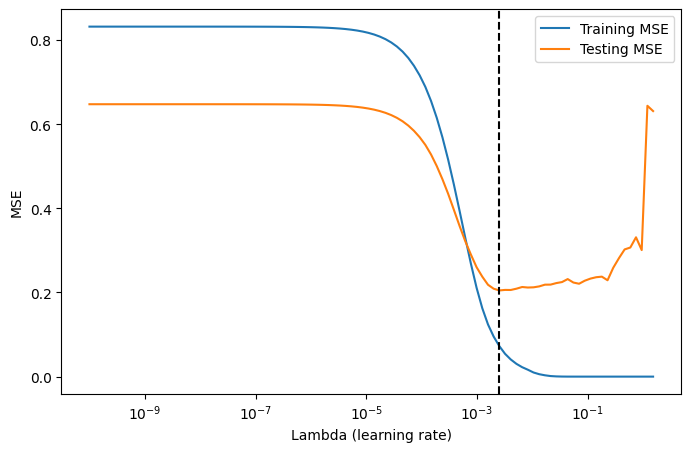

In [118]:
fig, ax = subplots(figsize=(8, 5))
ax.plot(lambda_range, mse_train, label='Training MSE')
ax.plot(lambda_range, mse_test, label='Testing MSE')
ax.set_xlabel('Lambda (learning rate)')
ax.set_ylabel('MSE')
ax.axvline(lambda_range[72], c='k', ls='--')
ax.set_xscale('log')
ax.legend();

**(e)** Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

In [97]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Lasso

In [102]:
n_alphas = 200
alphas = np.logspace(1, -3, n_alphas)

coefs = []
mse_train_lasso = []
mse_test_lasso = []
for alpha in alphas:
    lasso = skl.Lasso(alpha=alpha, max_iter=10000).fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)
    y_pred_train = lasso.predict(X_train_scaled)
    mse_train_lasso.append(mean_squared_error(y_train, y_pred_train))
    y_pred_test = lasso.predict(X_test_scaled)
    mse_test_lasso.append(mean_squared_error(y_test, y_pred_test))


In [108]:
np.argmin(mse_test_lasso), np.min(mse_test_lasso), alphas[94]

(94, 0.4360672515478147, 0.12898902612533086)

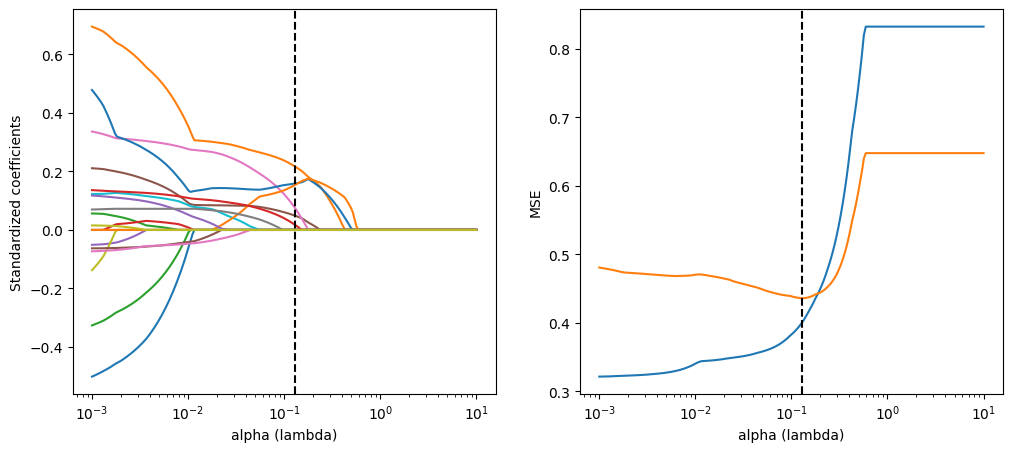

In [110]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(12,5))
ax1.plot(alphas, coefs)
ax1.axvline(alphas[94], c='k', ls='--')
ax1.set_xscale('log')
ax1.set_xlabel('alpha (lambda)')
ax1.set_ylabel('Standardized coefficients');

ax2.plot(alphas, mse_train_lasso, label='Training MSE')
ax2.plot(alphas, mse_test_lasso, label='Testing MSE')
ax2.axvline(alphas[94], c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel('alpha (lambda)')
ax2.set_ylabel('MSE');

Linear Regression

In [121]:
linear = LinearRegression(fit_intercept=True).fit(y=y_train, X=X_train)
y_pred_test_lin = linear.predict(X_test)
mean_squared_error(y_test, y_pred_test_lin) # As suspected

0.4917959375454939

Partial Least Squares

In [123]:
components = range(1, X_train_scaled.shape[1]+1)
scores = []

for comp in components:
    pls = PLSRegression(n_components=comp)
    score = -skm.cross_val_score(pls, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
    scores.append((score.mean(), score.std()))
scores = np.array(scores)

In [124]:
# CV finds minimum MSE at 12 components
scores[:,0].argmin()

11

In [128]:
pls = PLSRegression(n_components=12)
pls.fit(X_train_scaled, y_train)
y_pred_test_pls = pls.predict(X_test_scaled)
mean_squared_error(y_test, y_pred_test_pls)

0.47845915840645276

**(f)** Which variables appear to be the most important predictors in the boosted model?

In [147]:
# Final model (repeated here)
HittersGBR = GBR(n_estimators=1000, learning_rate=0.002542873574102705, max_depth=3, random_state=0).fit(X_train, y_train)
y_pred_test_GBR = HittersGBR.predict(X_test)
mean_squared_error(y_test, y_pred_test_GBR)

feature_importances = HittersGBR.feature_importances_
sort_idx = np.argsort(-feature_importances)
pos = np.arange(len(feature_importances))

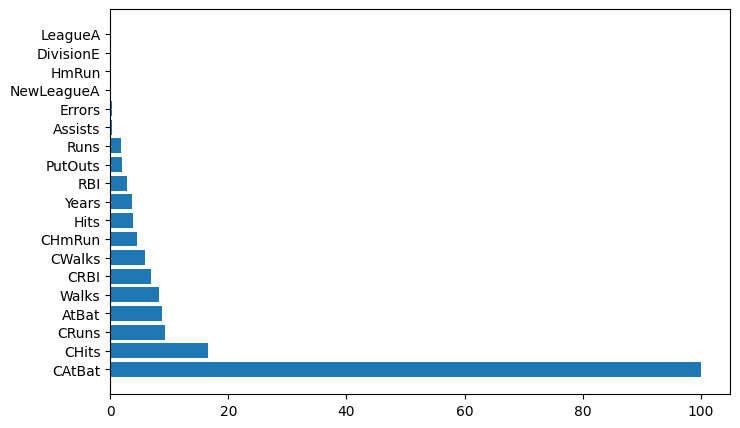

In [149]:
fig, ax = subplots(figsize=(8, 5))
ax.barh(pos, feature_importances[sort_idx]/np.max(feature_importances)*100)
ax.set_yticks(pos, X.columns[sort_idx]);

**(g)** Now apply bagging to the training set. What is the test set MSE for this approach?

In [155]:
p = X_train.shape[1]
HittersRandForest = RF(max_features=p, n_estimators=100, random_state=0).fit(X_train, y_train)

mean_squared_error(y_test, HittersRandForest.predict(X_test))

0.2345720457469322

The MSE is 0.235, very close to boosted decision trees, and half that of a linearn model, lasso, and partial least squares.

## 11

This question uses the `Caravan` data set.

**(a)** Create a training set consisting of the first 1,000 observations, and a test set consisting of the remaining observations.

In [160]:
Caravan = load_data('Caravan')

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(Caravan.dtypes)

In [186]:
Caravan['PurchaseBin'] = np.where(Caravan['Purchase']=='Yes', 1, 0)
y = Caravan['PurchaseBin']
X = Caravan.drop(['Purchase', 'PurchaseBin'], axis=1)

X_train = X.iloc[0:1000, :]
X_test = X.iloc[1000:Caravan.shape[0], :]
y_train = y.iloc[0:1000]
y_test = y.iloc[1000:Caravan.shape[0]]

Caravan_feature_names = X.columns

**(b)** Fit a boosting model to the training set with `Purchase` as the response and the other variables as predictors. Use 1,000 trees, and a shrinkage value of 0.01. Which predictors appear to be the most important?

In [193]:
CaravanGBR = GBR(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=0).fit(X_train, y_train)

In [194]:
feature_importances = CaravanGBR.feature_importances_
sort_idx = np.argsort(-feature_importances)
pos = np.arange(len(feature_importances))
feature_importances_v = feature_importances[sort_idx]/np.max(feature_importances)*100

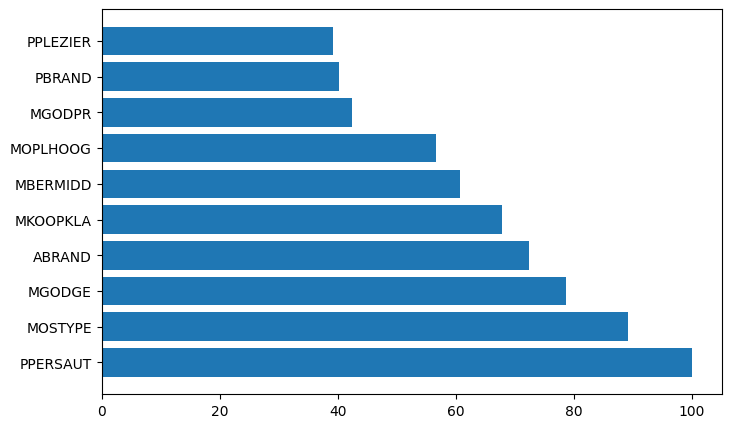

In [204]:
fig, ax = subplots(figsize=(8, 5))
ax.barh(pos[0:10], feature_importances_v[0:10])
ax.set_yticks(pos[0:10], X.columns[sort_idx[0:10]]);

The most important predictor is PPERSAUT Contribution car policies, followed by MOSTYPE Customer Subtype.

**(c)** Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20%. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?

In [214]:
y_pred_test_GBR = CaravanGBR.predict(X_test)
y_pred_test_GBR.mean() # 0.06
y_pred_test_GBR_labeled = np.where(y_pred_test_GBR >= 0.2, 1, 0)

In [215]:
confusion_table(y_test, y_pred_test_GBR_labeled)

Truth,0,1
Predicted,,
0,4271,262
1,247,42


In [225]:
print(f'{42/(42+247)*100:0.2f}% of people predicted to make a purchase actually make one.')

14.53% of people predicted to make a purchase actually make one.


Logistic Regression

In [222]:
CaravanLogit = LogisticRegression(C=1e10, solver='liblinear').fit(X_train, y_train)
y_pred_test_logit = CaravanLogit.predict_proba(X_test)
y_pred_test_logit_labeled = np.where(y_pred_test_logit[:,1] > 0.2, 1, 0)
confusion_table(y_pred_test_logit_labeled, y_test)

Truth,0,1
Predicted,,
0,4210,231
1,323,58


In [226]:
print(f'{58/(58+323)*100:0.2f}% of people predicted to make a purchase actually make one.')

15.22% of people predicted to make a purchase actually make one.


KNN Estimation

In [228]:
for K in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    accAll = accuracy_score(y_test, knn_pred)
    print(f'K = {K:3.0f} | Accuracy = {accAll:0.2f}')

K =   1 | Accuracy = 0.89
K =   2 | Accuracy = 0.94
K =   3 | Accuracy = 0.93
K =   4 | Accuracy = 0.94
K =   5 | Accuracy = 0.93
K =   6 | Accuracy = 0.94
K =   7 | Accuracy = 0.94
K =   8 | Accuracy = 0.94
K =   9 | Accuracy = 0.94


In [232]:
CaravanKNN = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train)
y_pred_test_KNN = CaravanKNN.predict(X_test)
confusion_table(y_test, y_pred_test_KNN)

Truth,0,1
Predicted,,
0,4525,8
1,287,2


In [230]:
print(f'{2/(2+287)*100:0.2f}% of people predicted to make a purchase actually make one.')

0.69% of people predicted to make a purchase actually make one.


Logistic regression performs the best, predicting 15.22$ of purchases, followed closely by gradient-boosted decision tree regression at 14.53%. KNN performs the worst at 0.69%.

## 12

Apply boosting, bagging, random forests, and BART to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to simple methods like linear or logistic regression? Which of these approaches yields the best performance?

In [4]:
Bikeshare = load_data('Bikeshare')
Bikeshare = pd.get_dummies(Bikeshare)
# Bikeshare.dtypes
Bikeshare.drop(['casual','registered'], axis=1, inplace=True) # 'casual' and 'registered' overlap with 'bikers'

In [5]:
X = Bikeshare.drop('bikers', axis=1)
y = Bikeshare['bikers']
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y, train_size=0.7, random_state=0)

### Boosting

In [ ]:
mse_train = []
mse_test = []
lambda_range = np.logspace(-5, np.log(1.5), 100)
for lam in lambda_range:
    BikeshareGBRloop = GBR(n_estimators=1000, learning_rate=lam, max_depth=3, random_state=0).fit(X_train, y_train)
    y_pred_train = BikeshareGBRloop.predict(X_train)
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    y_pred_test = BikeshareGBRloop.predict(X_test)
    mse_test.append(mean_squared_error(y_test, y_pred_test))

In [31]:
np.min(mse_test), lambda_range[np.argmin(mse_test)]

(1232.829924035506, 0.22882722484432472)

In [ ]:
# Final model
BikeshareGBR = GBR(n_estimators=1000, learning_rate=lambda_range[np.argmin(mse_test)], max_depth=3, random_state=0).fit(X_train, y_train)
y_pred_test_GBR = BikeshareGBR.predict(X_test)
mean_squared_error(y_test, y_pred_test_GBR)

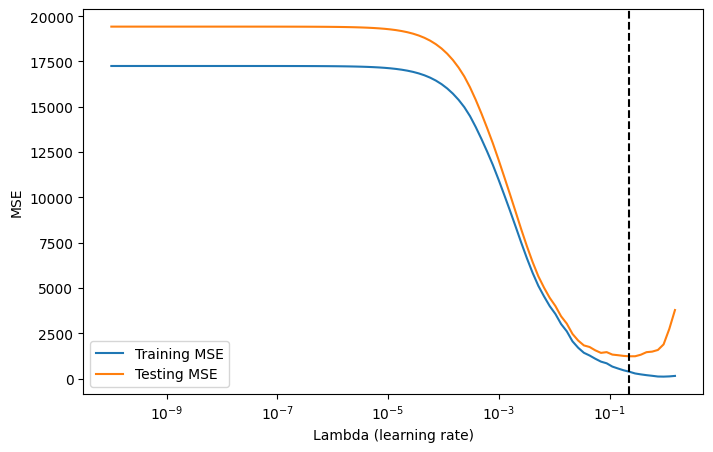

In [33]:
fig, ax = subplots(figsize=(8, 5))
ax.plot(lambda_range, mse_train, label='Training MSE')
ax.plot(lambda_range, mse_test, label='Testing MSE')
ax.set_xlabel('Lambda (learning rate)')
ax.set_ylabel('MSE')
ax.axvline(lambda_range[np.argmin(mse_test)], c='k', ls='--')
ax.set_xscale('log')
ax.legend();

### Bagging and Random Forests

In [7]:
p = X_train.shape[1]

mse_p = []
mse_p2 = []
mse_psqrt = []
tree_number = range(1,101)
for B in tree_number:
    BikeshareRandForest_p = RF(max_features=p, n_estimators=B, random_state=0).fit(X_train, y_train)
    BikeshareRandForest_p2 = RF(max_features=int(p/2), n_estimators=B, random_state=0).fit(X_train, y_train)
    BikeshareRandForest_psqrt = RF(max_features=int(np.sqrt(p)), n_estimators=B, random_state=0).fit(X_train, y_train)
    mse_p.append(mean_squared_error(y_test, BikeshareRandForest_p.predict(X_test)))
    mse_p2.append(mean_squared_error(y_test, BikeshareRandForest_p2.predict(X_test)))
    mse_psqrt.append(mean_squared_error(y_test, BikeshareRandForest_psqrt.predict(X_test)))

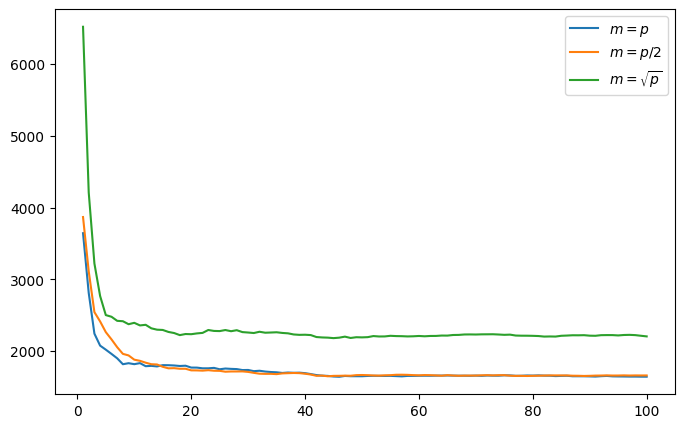

In [8]:
fig, ax = subplots(figsize=(8,5))
ax.plot(tree_number, mse_p, c='tab:blue', label='$m=p$')
ax.plot(tree_number, mse_p2, c='tab:orange', label='$m=p/2$')
ax.plot(tree_number, mse_psqrt, c='tab:green', label='$m=\sqrt{p}$')
ax.legend();

In [9]:
np.min(mse_p), tree_number[np.argmin(mse_p)]

(1640.7592748934942, 46)

In [10]:
np.min(mse_p2), tree_number[np.argmin(mse_p2)]

(1647.7037155036735, 44)

### Bayesian Additive Regression Tree

In [12]:
BikeshareBART = BART(random_state=0, burnin=5, ndraw=15).fit(X_train, y_train)
y_pred_test_BART = BikeshareBART.predict(np.asarray(X_test))
mean_squared_error(y_test, y_pred_test_BART), BikeshareBART.score(np.asarray(X_test), y_test)

(5217.177010579458, 0.7312057678071475)

In summary, gradient-boosting regression trees performs best, with an MSE of 1232; bagging comes in second, with an MSE of 640; random forests with an MSE of 1647; and bayestian additive regression trees with an MSE of 5217.